In [52]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns


# Para preprocesamiento y modelado
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.feature_selection import f_classif, SelectKBest

# Ignorar warnings (opcional)
import warnings
warnings.filterwarnings("ignore")

# 1. CARGA DE DATOS

df = pd.read_csv("/workspaces/ejercicio_regresion_lineal/data/raw/medical_insurance_cost.csv")

df.head()



,age,sex,bmi,children,smoker,region,charges
0,19,female,27.900,0,yes,southwest,16884.92400
1,18,male,33.770,1,no,southeast,1725.55230
2,28,male,33.000,3,no,southeast,4449.46200
3,33,male,22.705,0,no,northwest,21984.47061
4,32,male,28.880,0,no,northwest,3866.85520


In [53]:
# Dimensiones del dataset
print("Shape (filas, columnas):", df.shape)

# Información de tipos de datos y nulos
df.info()

# Descripción estadística de numéricas
df.describe()


Shape (filas, columnas): (1338, 7)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1338 entries, 0 to 1337
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       1338 non-null   int64  
 1   sex       1338 non-null   object 
 2   bmi       1338 non-null   float64
 3   children  1338 non-null   int64  
 4   smoker    1338 non-null   object 
 5   region    1338 non-null   object 
 6   charges   1338 non-null   float64
dtypes: float64(2), int64(2), object(3)
memory usage: 73.3+ KB


,age,bmi,children,charges
count,1338.000000,1338.000000,1338.000000,1338.000000
mean,39.207025,30.663397,1.094918,13270.422265
std,14.049960,6.098187,1.205493,12110.011237
min,18.000000,15.960000,0.000000,1121.873900
25%,27.000000,26.296250,0.000000,4740.287150
50%,39.000000,30.400000,1.000000,9382.033000
75%,51.000000,34.693750,2.000000,16639.912515
max,64.000000,53.130000,5.000000,63770.428010


Detección de duplicados

In [54]:
print("Número de filas duplicadas:", df.duplicated().sum())

# Si quisieras eliminar duplicados:
df = df.drop_duplicates()
print("Shape tras eliminar duplicados:", df.shape)


Número de filas duplicadas: 1
Shape tras eliminar duplicados: (1337, 7)


Revisión rápida de valores nulos

In [55]:
print("Valores nulos totales por columna:")
print(df.isnull().sum())


Valores nulos totales por columna:
age         0
sex         0
bmi         0
children    0
smoker      0
region      0
charges     0
dtype: int64


In [56]:
# Información de tipos de datos y nulos
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1337 entries, 0 to 1337
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       1337 non-null   int64  
 1   sex       1337 non-null   object 
 2   bmi       1337 non-null   float64
 3   children  1337 non-null   int64  
 4   smoker    1337 non-null   object 
 5   region    1337 non-null   object 
 6   charges   1337 non-null   float64
dtypes: float64(2), int64(2), object(3)
memory usage: 83.6+ KB


Factorizar variables categoricas

# INVESTIGAR: ONE HOT ENCODING

In [57]:
# import pandas as pd
# import json

# def one_hot_encode_and_save(df, output_file='transformacion.json'):
#     """
#     Realiza One-Hot Encoding en un DataFrame, identifica automáticamente las columnas categóricas,
#     y guarda el resultado en un archivo JSON.

#     Parámetros:
#     df (pd.DataFrame): DataFrame a transformar.
#     output_file (str): Nombre del archivo de salida JSON (por defecto 'transformacion.json').
#     """
#     # Paso 2: Identificar columnas categóricas
#     # Las columnas categóricas suelen ser de tipo 'object' en pandas
#     categorical_columns = df.select_dtypes(include=['object']).columns
    
#     # Paso 3: Aplicar One-Hot Encoding
#     df_encoded = pd.get_dummies(df, columns=categorical_columns, prefix=categorical_columns, prefix_sep='_')
    
#     # Paso 4: Guardar el resultado en un archivo JSON
#     # Convertimos el DataFrame a un diccionario y luego a JSON
#     df_encoded_dict = df_encoded.to_dict(orient='records')
#     with open(output_file, 'w') as json_file:
#         json.dump(df_encoded_dict, json_file, indent=4)
    
#     print(f"Dataset transformado guardado en {output_file}")

# # Ejemplo de uso de la función
# df = pd.read_csv("/workspaces/ejercicio_regresion_logistica/data/raw/bank-marketing-campaign-data.csv", sep=";")  # Asumiendo que ya tenemos un DataFrame cargado
# one_hot_encode_and_save(df)

a) Histplot para algunas variables numéricas

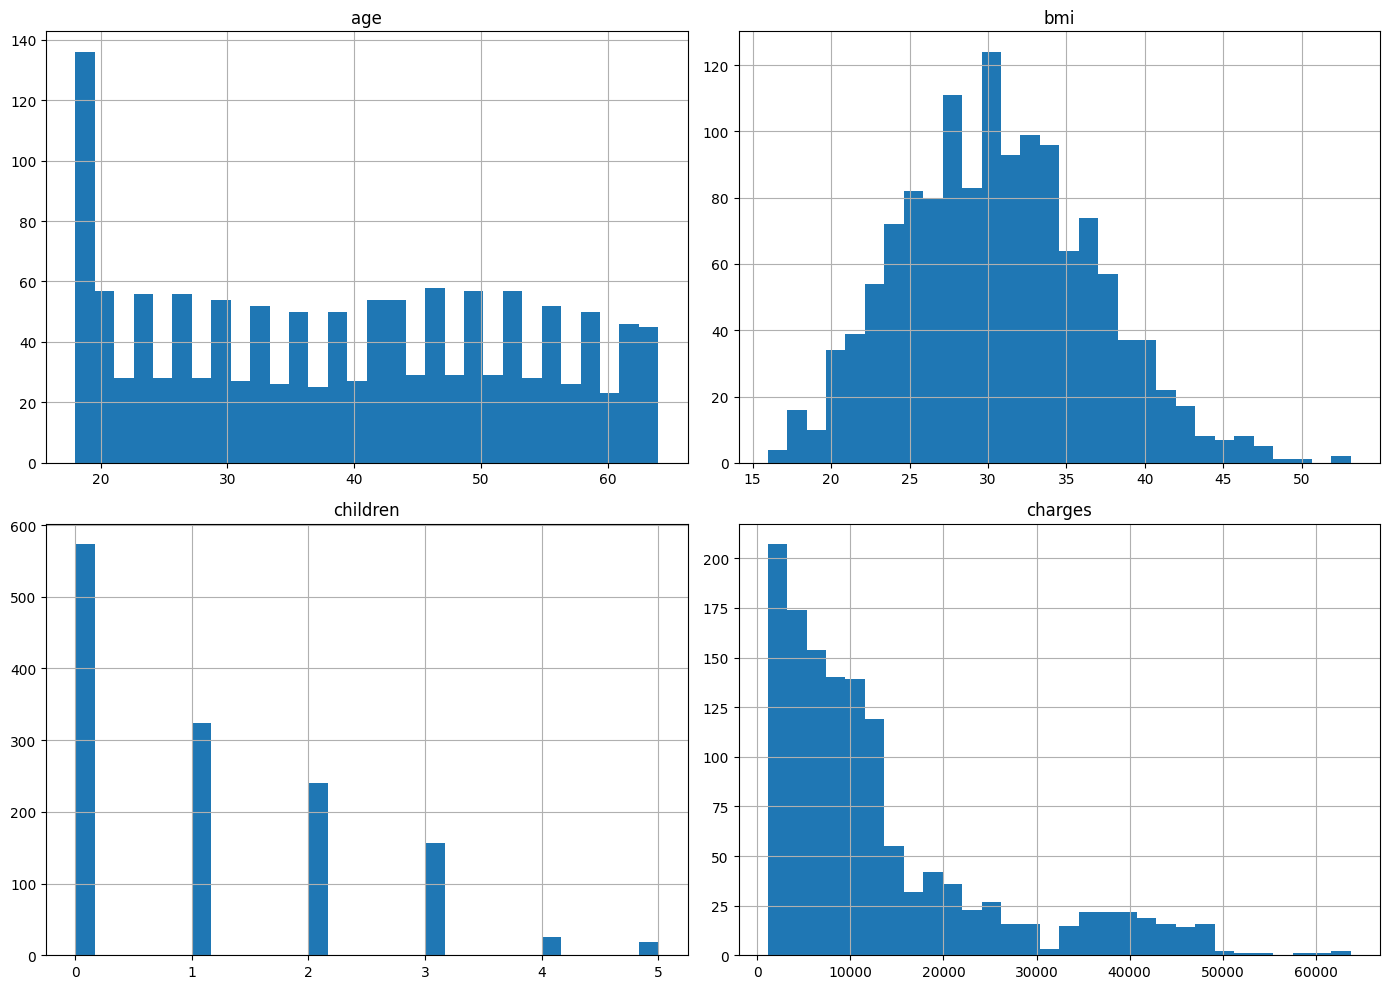

In [58]:
# Detectar columnas numéricas
numeric_cols = df.select_dtypes(include=[np.number]).columns.tolist()

# Generar histogramas para las columnas numéricas
df[numeric_cols].hist(figsize=(14, 10), bins=30)
plt.tight_layout()
plt.show()


b) Countplot para algunas variables categóricas

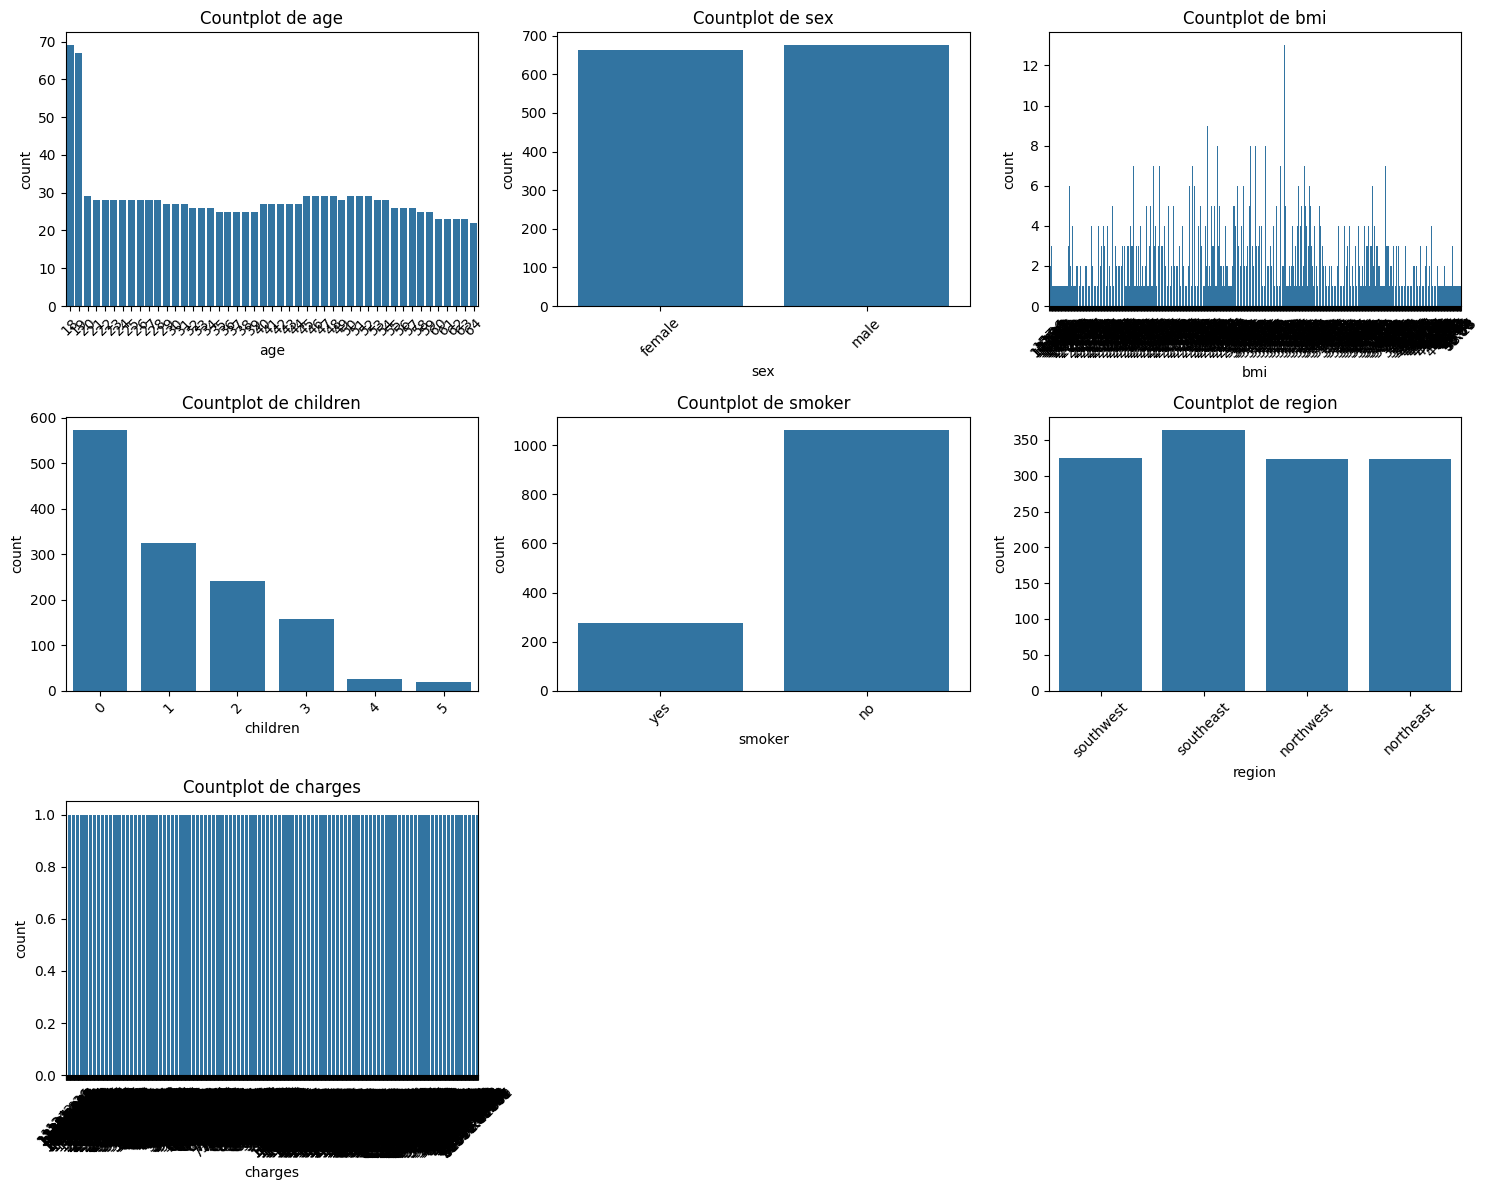

In [59]:
# Selecciona las columnas categóricas (tipo 'object')
categorical_cols = df.select_dtypes(include=['object', 'int64', 'float64']).columns

# Calcula el número de filas y columnas para los subplots
num_plots = len(categorical_cols)
ncols = 3
nrows = (num_plots + ncols - 1) // ncols  # Asegúrate de tener suficientes filas

fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(15, nrows*4))
axes = axes.flatten()

for i, col in enumerate(categorical_cols):
    if i < len(axes):
        sns.countplot(data=df, x=col, ax=axes[i])
        axes[i].set_title(f"Countplot de {col}")
        axes[i].tick_params(axis='x', rotation=45)

# Oculta los ejes no utilizados
for j in range(num_plots, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()


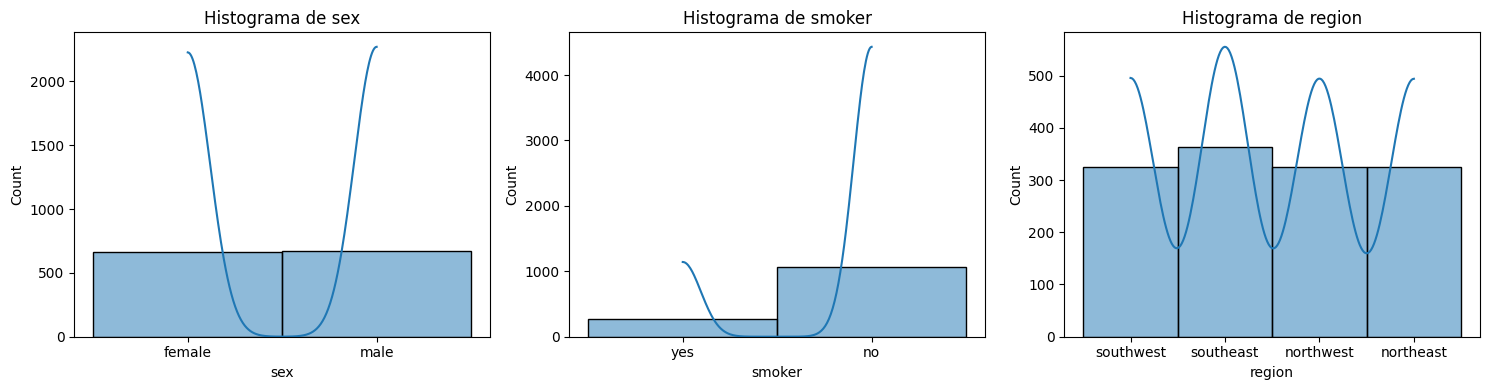

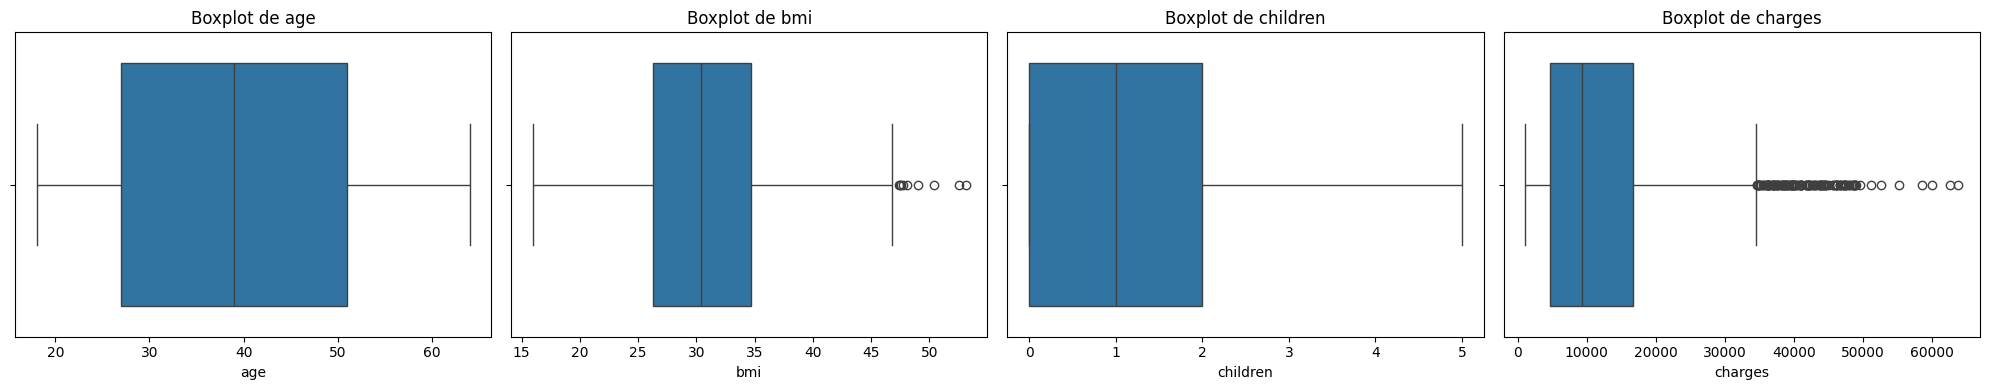

In [60]:
import seaborn as sns
import matplotlib.pyplot as plt
import math

# Clasificar columnas según su tipo
categorical_cols = df.select_dtypes(include=['object', 'category']).columns
numerical_cols = df.select_dtypes(include=['int64', 'float64']).columns

# Definir función para gráficos en cuadrícula
def plot_grid(columns, plot_func, title, n_cols=3):
    n_rows = math.ceil(len(columns) / n_cols)  # Calcular número de filas
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(5 * n_cols, 4 * n_rows))
    axes = axes.flatten()  # Asegurar compatibilidad con iteración

    for i, col in enumerate(columns):
        plot_func(df, col, axes[i])  # Función para graficar
        axes[i].set_title(f"{title} de {col}")
    
    # Ocultar los ejes sobrantes (si hay más espacios que gráficos)
    for j in range(i + 1, len(axes)):
        fig.delaxes(axes[j])  # Eliminar subgráficos vacíos

    plt.tight_layout()
    plt.show()

# Crear funciones específicas para histogramas y boxplots
def hist_plot(data, column, ax):
    sns.histplot(data=data, x=column, kde=True, ax=ax)

def box_plot(data, column, ax):
    sns.boxplot(data=data, x=column, y=None, ax=ax)

# Graficar variables categóricas (histogramas)
plot_grid(categorical_cols, hist_plot, "Histograma", n_cols=3)

# Graficar variables numéricas (boxplots)
plot_grid(numerical_cols, box_plot, "Boxplot", n_cols=4)



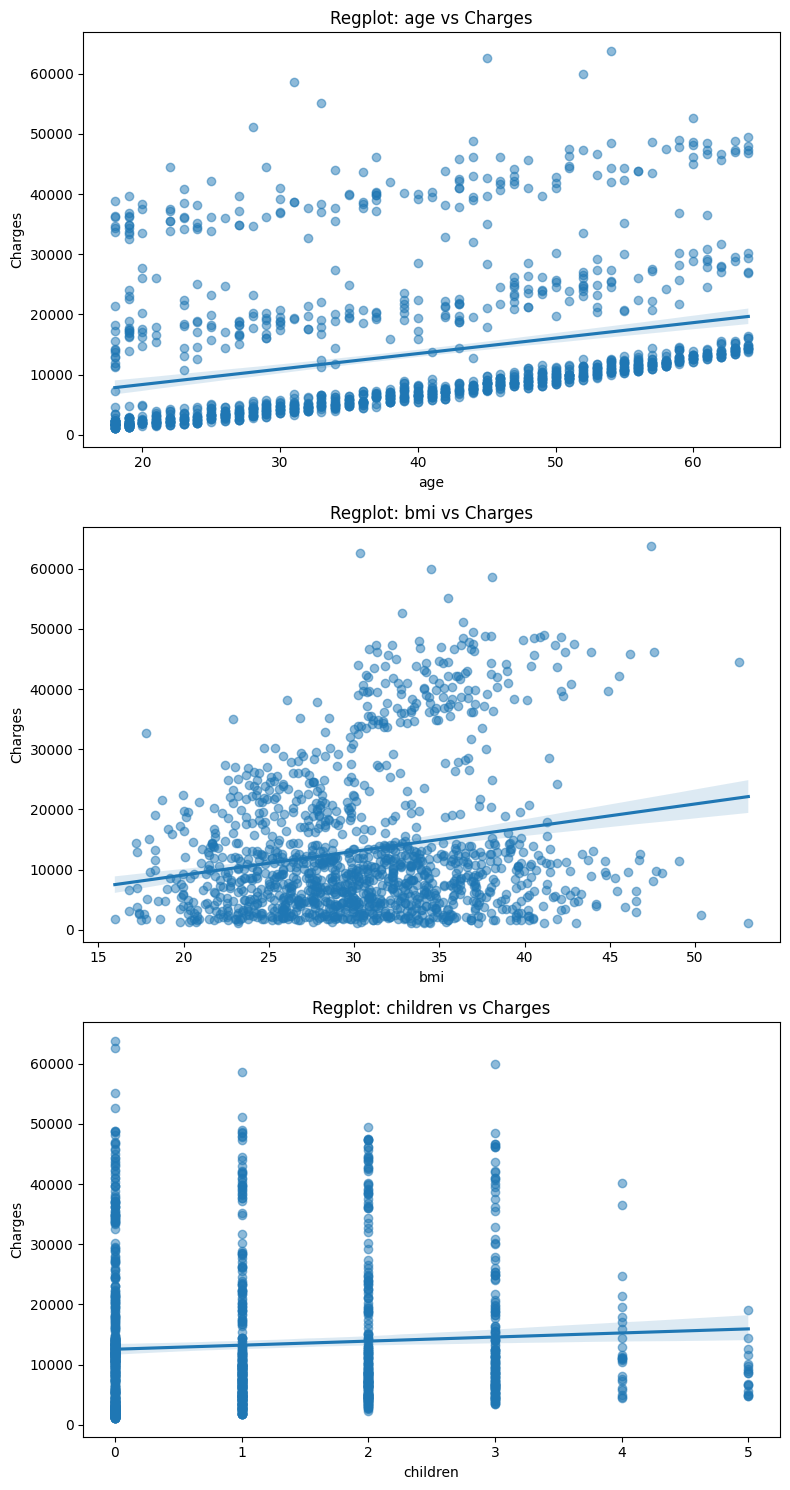

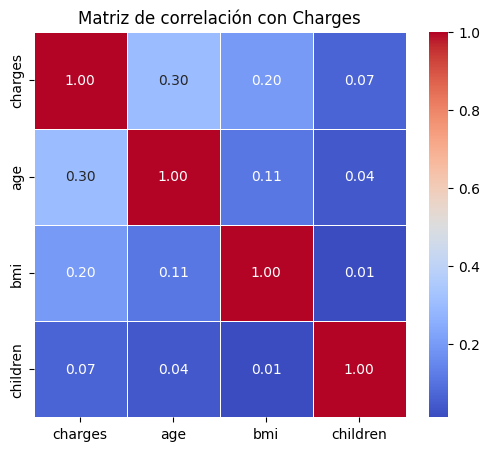

In [61]:
import seaborn as sns
import matplotlib.pyplot as plt

# Identificar columnas numéricas excluyendo la target 'charges'
numerical_cols = df.select_dtypes(include=['int64', 'float64']).columns.drop('charges')

# Crear una figura con subplots dinámicos según la cantidad de variables
fig, axes = plt.subplots(len(numerical_cols), 1, figsize=(8, 5 * len(numerical_cols)))

# Si solo hay una variable, convertir axes en una lista para evitar errores de indexación
if len(numerical_cols) == 1:
    axes = [axes]

# Graficar cada variable contra 'charges' en un subplot diferente
for i, col in enumerate(numerical_cols):
    sns.regplot(data=df, x=col, y='charges', ax=axes[i], scatter_kws={'alpha': 0.5})
    axes[i].set_title(f"Regplot: {col} vs Charges")
    axes[i].set_xlabel(col)
    axes[i].set_ylabel("Charges")

# Ajustar el diseño para evitar solapamientos
plt.tight_layout()
plt.show()

# Heatmap con correlaciones de todas las variables numéricas respecto a 'charges'
plt.figure(figsize=(6, 5))
correlation_matrix = df[['charges']].join(df[numerical_cols]).corr()
sns.heatmap(correlation_matrix, annot=True, cmap="coolwarm", fmt=".2f", linewidths=0.5)
plt.title("Matriz de correlación con Charges")
plt.show()





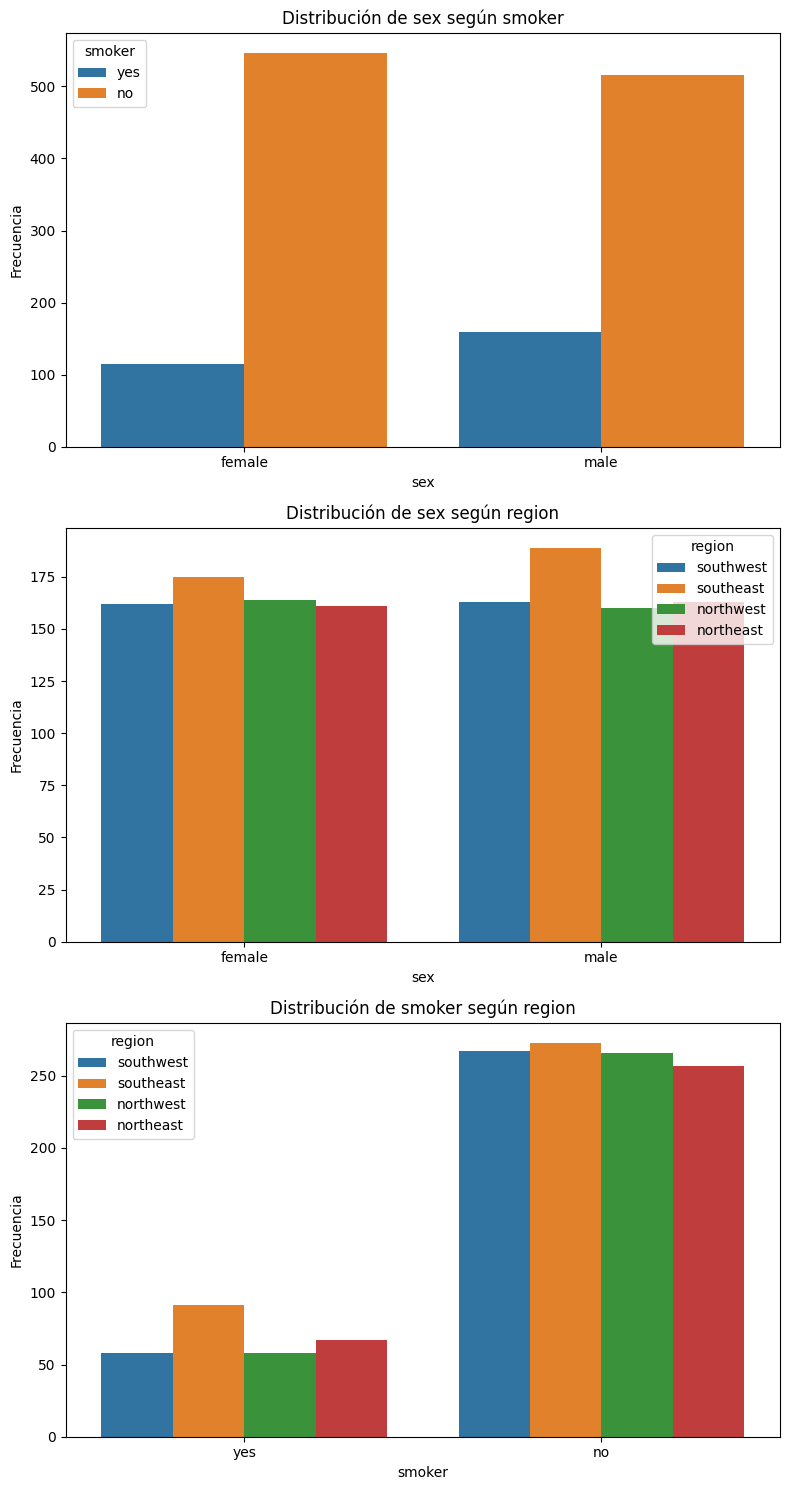

In [62]:
import seaborn as sns
import matplotlib.pyplot as plt
import itertools  # Para hacer combinaciones de pares de variables categóricas

# Identificar columnas categóricas
categorical_cols = df.select_dtypes(include=['object']).columns

# Generar todas las combinaciones posibles de pares de variables categóricas
category_pairs = list(itertools.combinations(categorical_cols, 2))

# Crear subplots para cada combinación de variables categóricas
fig, axes = plt.subplots(len(category_pairs), 1, figsize=(8, 5 * len(category_pairs)))

# Si solo hay una pareja, convertir axes en lista para evitar errores de indexación
if len(category_pairs) == 1:
    axes = [axes]

# Graficar cada combinación de variables categóricas
for i, (cat1, cat2) in enumerate(category_pairs):
    sns.countplot(data=df, x=cat1, hue=cat2, ax=axes[i])
    axes[i].set_title(f"Distribución de {cat1} según {cat2}")
    axes[i].set_xlabel(cat1)
    axes[i].set_ylabel("Frecuencia")

# Ajustar el diseño para evitar solapamientos
plt.tight_layout()
plt.show()



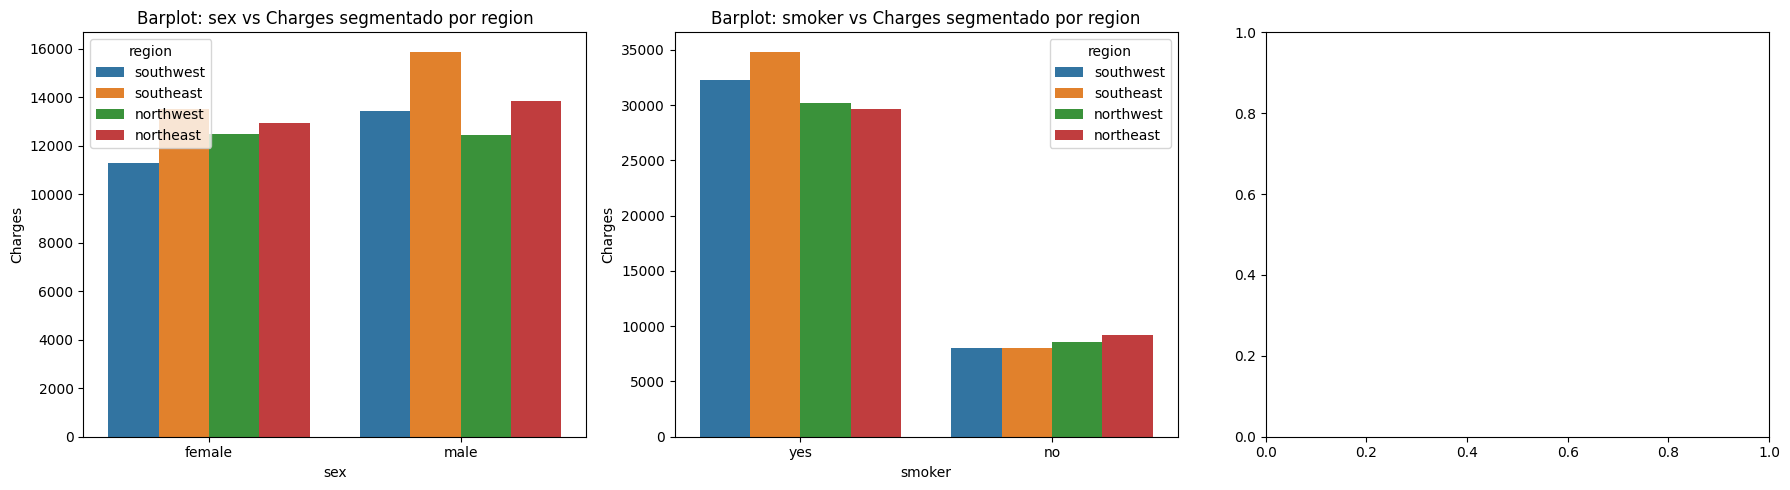

In [63]:
import seaborn as sns
import matplotlib.pyplot as plt

# Identificar columnas categóricas
categorical_cols = df.select_dtypes(include=['object']).columns

# Definir una columna para segmentar (puedes cambiarlo según tu dataset)
hue_col = 'region'  # Cámbialo por otra variable categórica si prefieres

# Crear la figura con subplots
fig, axes = plt.subplots(1, len(categorical_cols), figsize=(6 * len(categorical_cols), 5))

# Si solo hay una variable categórica, convertir axes en una lista para evitar errores
if len(categorical_cols) == 1:
    axes = [axes]

# Graficar cada variable categórica con un hue adicional
for i, cat_col in enumerate(categorical_cols):
    if cat_col != hue_col:  # Evitar usar la misma variable en X y en hue
        sns.barplot(data=df, x=cat_col, y='charges', hue=hue_col, ax=axes[i], estimator='mean', ci=None)
        axes[i].set_title(f"Barplot: {cat_col} vs Charges segmentado por {hue_col}")
        axes[i].set_xlabel(cat_col)
        axes[i].set_ylabel("Charges")

# Ajustar el diseño
plt.tight_layout()
plt.show()


In [64]:
import pandas as pd
import json

def factorize_all_categoricals(df, save_json=True, json_filename="categorical_transformation_rules.json"):
    """
    Detecta todas las columnas categóricas en el DataFrame, las factoriza y guarda
    el mapeo de transformación (valor original a código numérico) en un archivo JSON.
    
    Se crea una nueva columna para cada columna categórica con el sufijo "_n".
    
    Parameters:
      df (pd.DataFrame): DataFrame de entrada.
      save_json (bool): Si True, guarda el mapeo en un archivo JSON.
      json_filename (str): Nombre del archivo JSON para guardar el mapeo.
      
    Returns:
      df (pd.DataFrame): DataFrame modificado con columnas factorizadas.
      transformation_rules (dict): Diccionario con el mapeo de cada columna categórica.
    """
    # Detectar columnas categóricas
    cat_cols = df.select_dtypes(include=['object', 'category']).columns.tolist()
    transformation_rules = {}
    
    for col in cat_cols:
        # Factorizar la columna
        codes, uniques = pd.factorize(df[col])
        df[col + "_n"] = codes  # Nueva columna con los códigos
        
        # Crear el mapeo: {valor_original: código}
        mapping = {value: code for code, value in enumerate(uniques)}
        transformation_rules[col] = mapping

    # Guardar el mapeo en un archivo JSON si se desea
    if save_json:
        with open(json_filename, "w") as f:
            json.dump(transformation_rules, f, indent=4)
        print(f"Transformation rules saved in {json_filename}")

    return df, transformation_rules

# Ejemplo de uso:
# Supongamos que ya tienes un DataFrame "df"
df, transformation_rules = factorize_all_categoricals(df)

Transformation rules saved in categorical_transformation_rules.json


Correlación (Heatmap) de las variables numéricas y categoricas

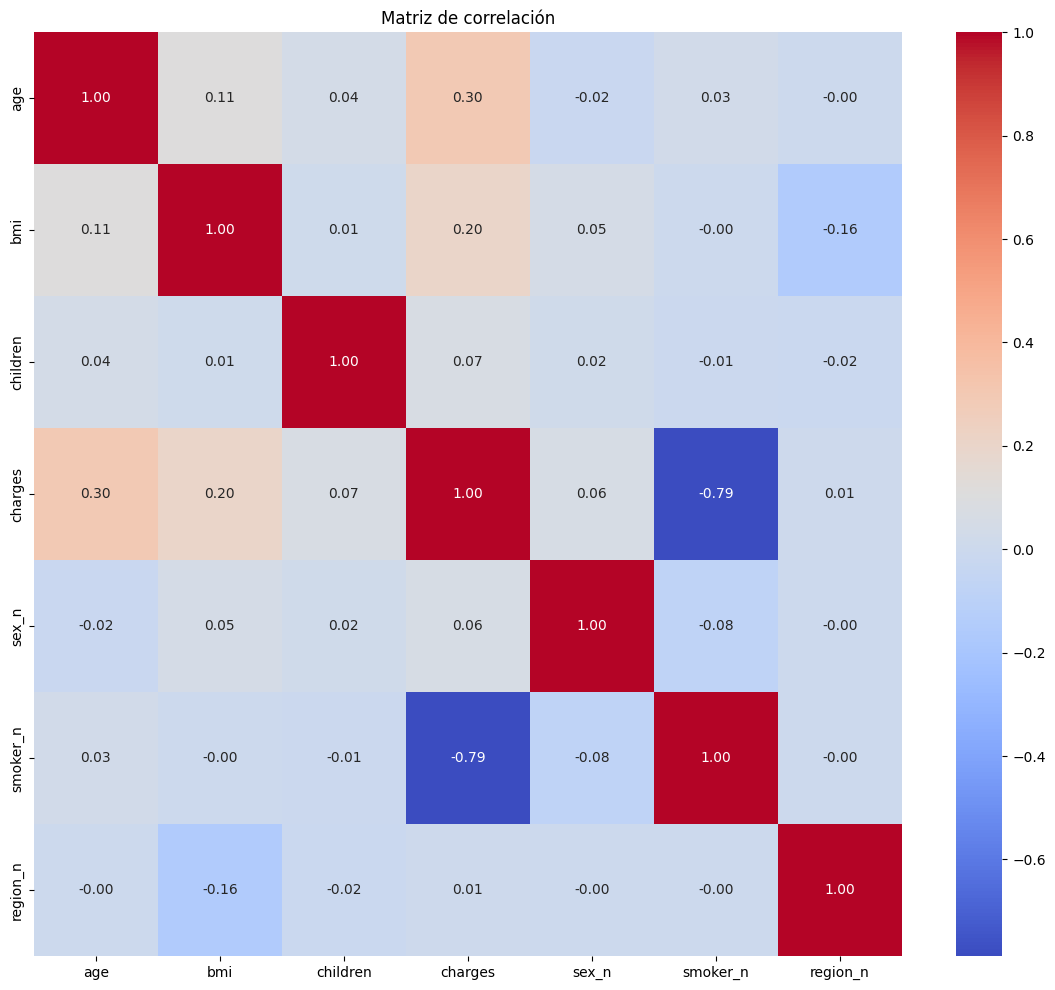

In [65]:
# Ruta al archivo JSON con las reglas de factorización
json_file_path = "/workspaces/ejercicio_regresion_lineal/src/categorical_transformation_rules.json"

# Cargar el archivo JSON
with open(json_file_path, 'r') as file:
    factorization_rules = json.load(file)

# Aplicar la factorización a las columnas categóricas según las reglas del archivo JSON
for col, mapping in factorization_rules.items():
    df[col + "_n"] = df[col].map(mapping)

# Seleccionar todas las columnas numéricas en el DataFrame
numeric_cols = df.select_dtypes(include=['number']).columns

# Crear la matriz de correlación
corr_matrix = df[numeric_cols].corr()

# Graficar la matriz de correlación
plt.figure(figsize=(14, 12))
sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap="coolwarm")
plt.title("Matriz de correlación")
plt.show()


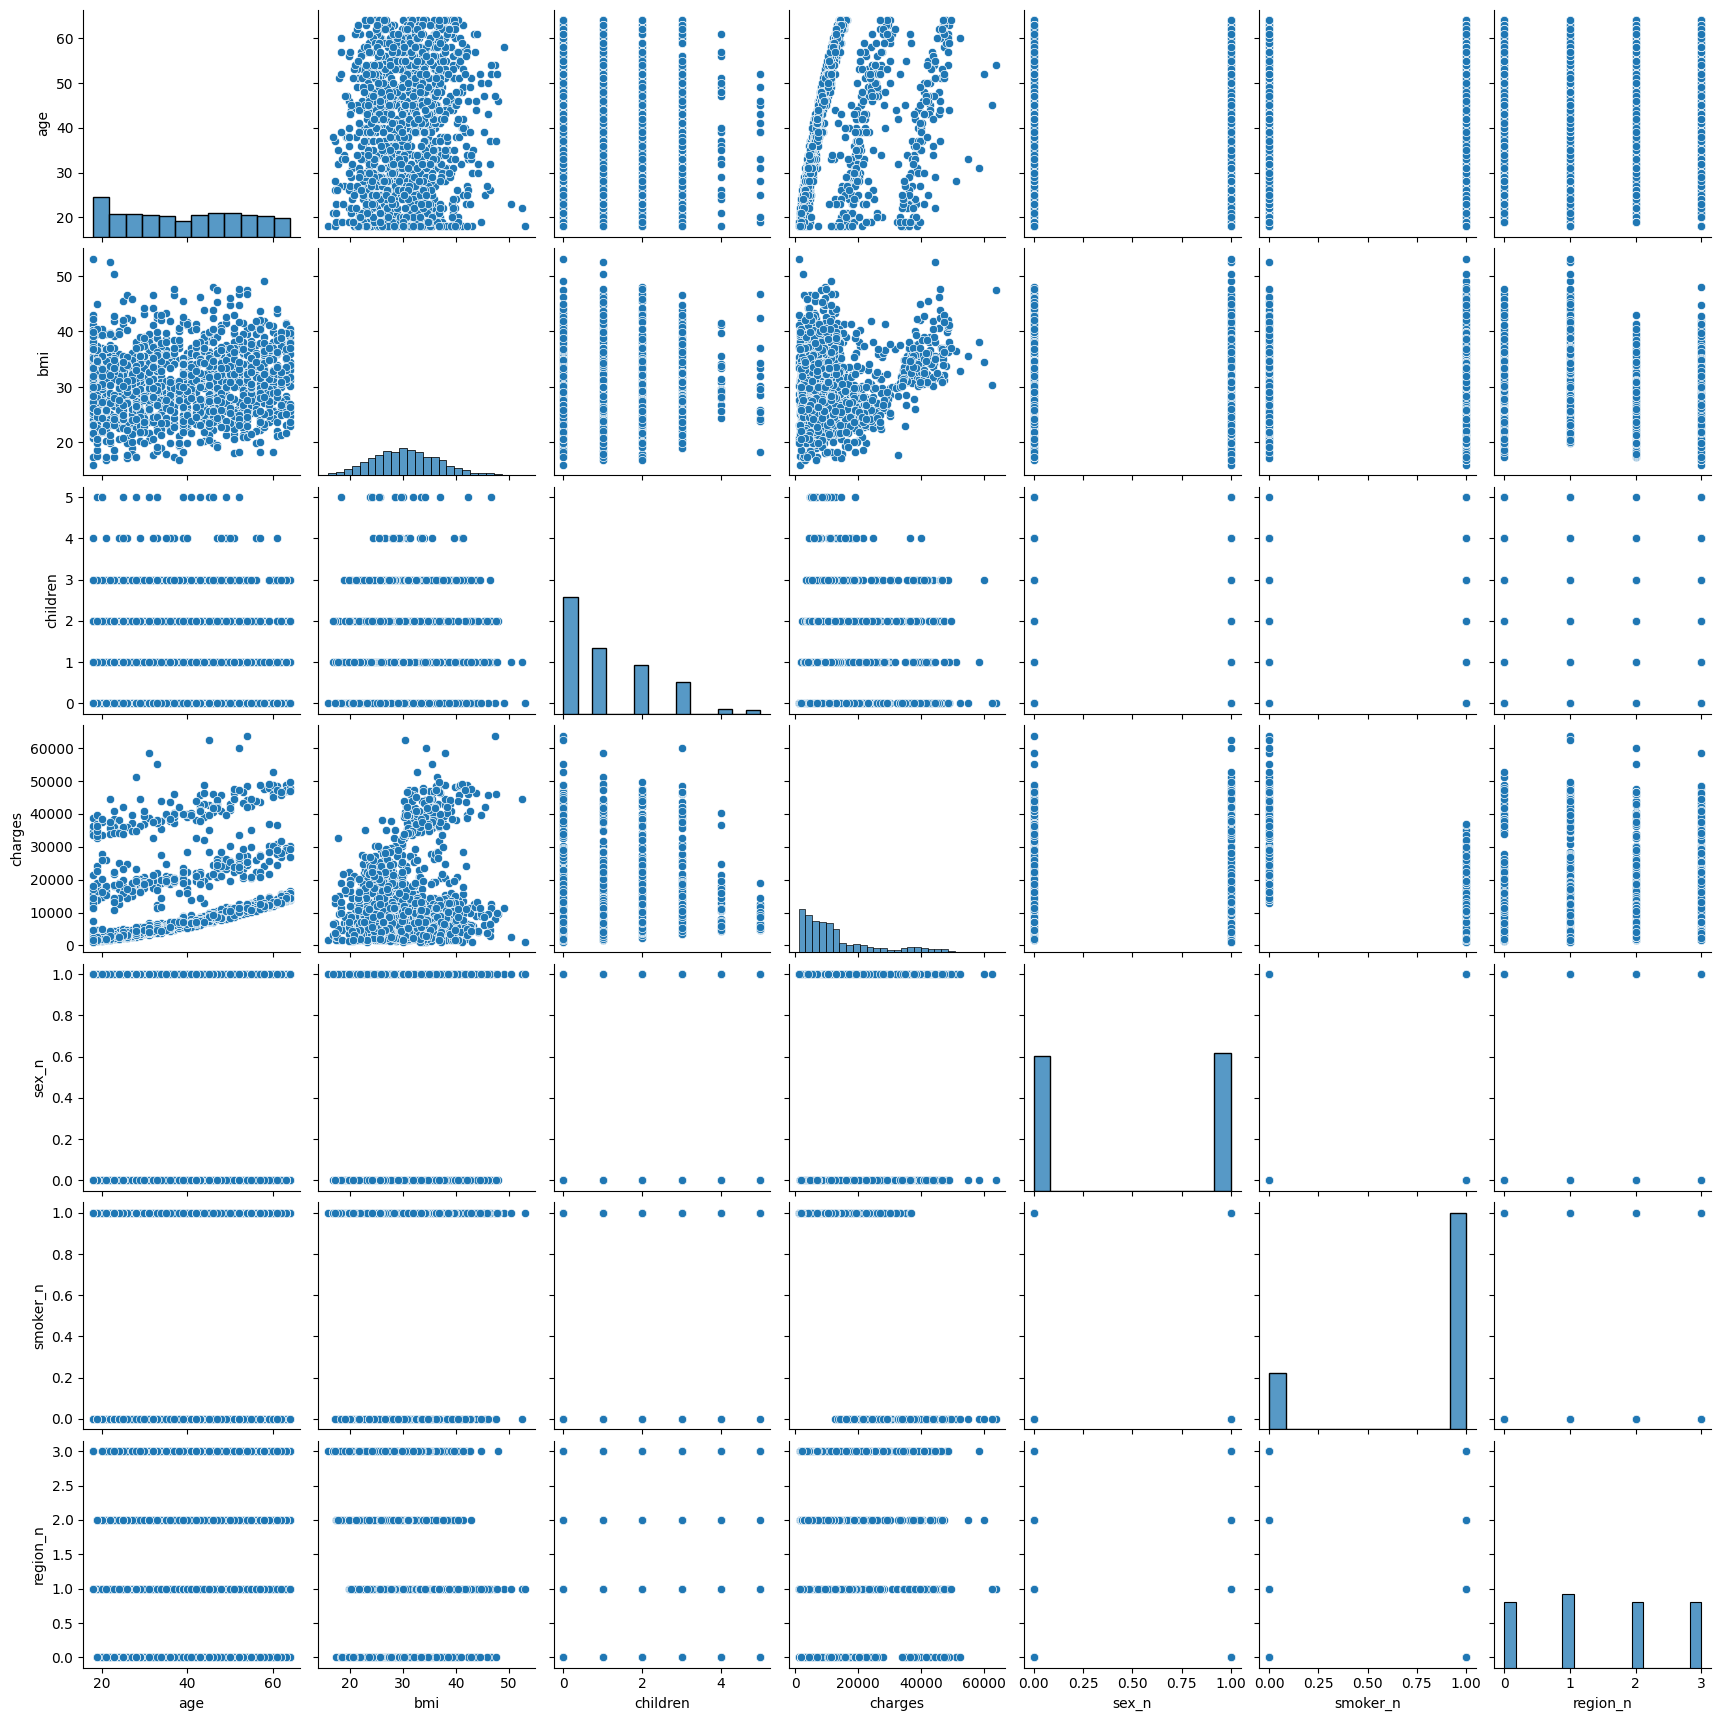

In [66]:
sns.pairplot(data = df)

In [67]:
df.describe()

,age,bmi,children,charges,sex_n,smoker_n,region_n
count,1337.000000,1337.000000,1337.000000,1337.000000,1337.000000,1337.000000,1337.000000
mean,39.222139,30.663452,1.095737,13279.121487,0.504862,0.795064,1.483919
std,14.044333,6.100468,1.205571,12110.359656,0.500163,0.403806,1.105208
min,18.000000,15.960000,0.000000,1121.873900,0.000000,0.000000,0.000000
25%,27.000000,26.290000,0.000000,4746.344000,0.000000,1.000000,1.000000
50%,39.000000,30.400000,1.000000,9386.161300,1.000000,1.000000,1.000000
75%,51.000000,34.700000,2.000000,16657.717450,1.000000,1.000000,2.000000
max,64.000000,53.130000,5.000000,63770.428010,1.000000,1.000000,3.000000


In [68]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1337 entries, 0 to 1337
Data columns (total 10 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       1337 non-null   int64  
 1   sex       1337 non-null   object 
 2   bmi       1337 non-null   float64
 3   children  1337 non-null   int64  
 4   smoker    1337 non-null   object 
 5   region    1337 non-null   object 
 6   charges   1337 non-null   float64
 7   sex_n     1337 non-null   int64  
 8   smoker_n  1337 non-null   int64  
 9   region_n  1337 non-null   int64  
dtypes: float64(2), int64(5), object(3)
memory usage: 114.9+ KB


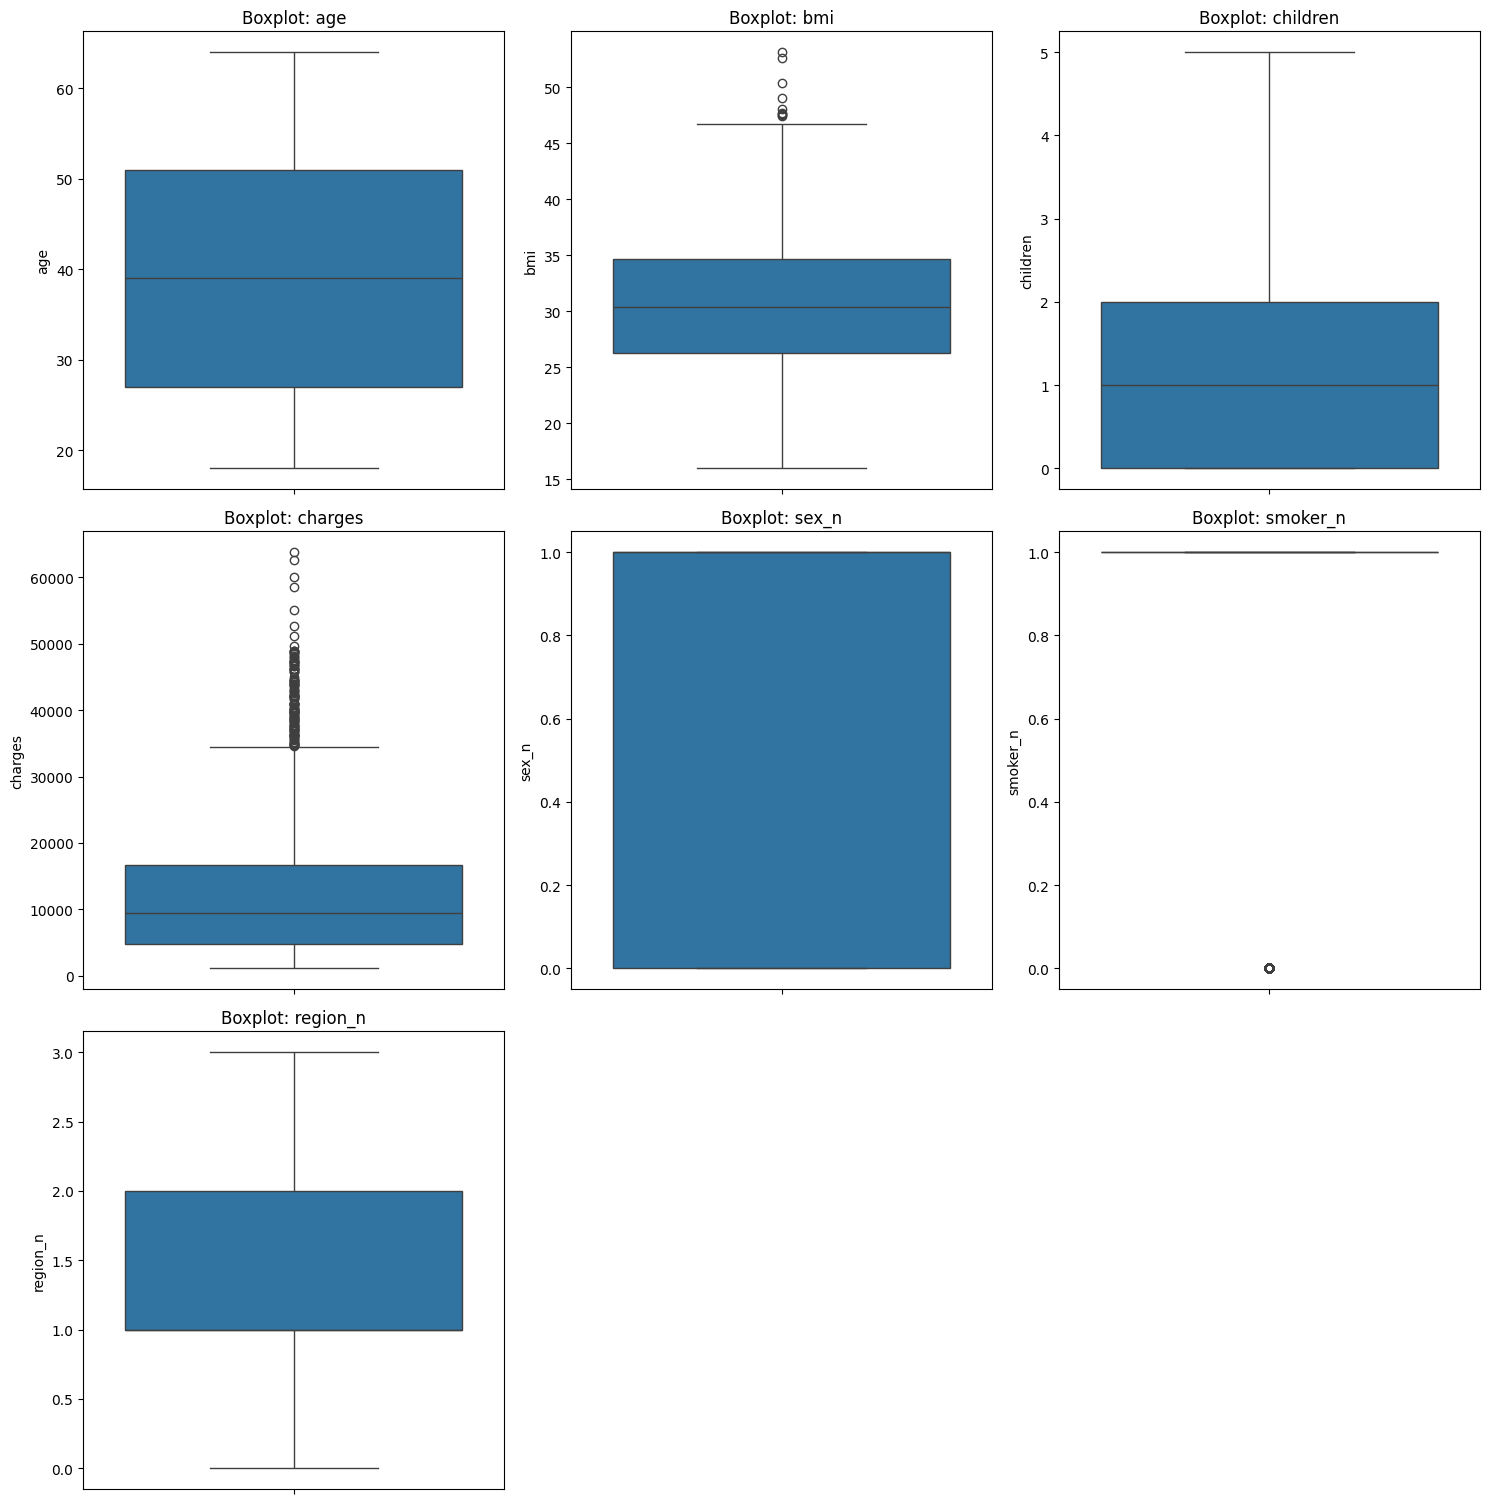

In [69]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
 
# Filtrar las columnas de tipo float64 e int64
numerical_columns = df.select_dtypes(include=['float64', 'int64'])
 
# Configuración para subplots (3 gráficos por fila)
num_cols = 3  # Número de gráficos por fila
num_plots = len(numerical_columns)  # Número total de gráficos
num_rows = (num_plots + num_cols - 1) // num_cols  # Calcular filas necesarias
 
# Crear el espacio para subplots
fig, axes = plt.subplots(num_rows, num_cols, figsize=(15, 5 * num_rows))  # Ajustar la figura
 
# Asegurarnos de que 'axes' sea una matriz plana para iterar fácilmente
axes = axes.flatten()
 
# Iterar sobre cada columna y graficar en el espacio asignado
for i, column in enumerate(numerical_columns):
   sns.boxplot(data=df, y=column, ax=axes[i])  # Cambiar 'x' por 'y' para orientación vertical
   axes[i].set_title(f"Boxplot: {column}")
 
# Eliminar ejes vacíos si hay menos gráficos que espacios
for j in range(i + 1, len(axes)):
   fig.delaxes(axes[j])
 
# Ajustar la distribución de los gráficos
plt.tight_layout()
plt.show()

Selección de variables (features)

In [70]:
import json
 
# Copiar el dataframe para trabajar con los datos con y sin outliers
df_con_outliers = df.copy()
df_sin_outliers = df.copy()
 
# Función para reemplazar los outliers de una columna en un dataframe
def replace_outliers_from_column(column, df):
   column_stats = df[column].describe()  # Calcular estadísticas de la columna
   column_iqr = column_stats["75%"] - column_stats["25%"]  # Rango intercuartílico (IQR)
   upper_limit = column_stats["75%"] + 1.5 * column_iqr  # Límite superior
   lower_limit = column_stats["25%"] - 1.5 * column_iqr  # Límite inferior
 
   # Reemplazar los outliers superiores por el límite superior
   df[column] = df[column].apply(lambda x: x if (x <= upper_limit) else upper_limit)
   # Reemplazar los outliers inferiores por el límite inferior
   df[column] = df[column].apply(lambda x: x if (x >= lower_limit) else lower_limit)
 
   # Devuelve el dataframe modificado y los límites de los outliers
   return df.copy(), [lower_limit, upper_limit]
 
# Filtrar solo las columnas numéricas (float64 e int64)
numerical_columns = df.select_dtypes(include=["float64", "int64"]).columns
 
# Diccionario para almacenar los límites de outliers para cada columna
outliers_dict = {}
 
# Aplicar la función a cada columna numérica
for column in numerical_columns:
   df_sin_outliers, limits_list = replace_outliers_from_column(column, df_sin_outliers)
   outliers_dict[column] = limits_list  # Guardar los límites en el diccionario
 
# Guardar los límites de los outliers en un archivo JSON
with open("outliers_replacement.json", "w") as f:
   json.dump(outliers_dict, f)
 
# Mostrar el diccionario con los límites de cada columna, línea por línea
print("Límites de outliers para cada columna:")
for key, value in outliers_dict.items():
   print(f"{key}: {value}")


Límites de outliers para cada columna:
age: [np.float64(-9.0), np.float64(87.0)]
bmi: [np.float64(13.674999999999994), np.float64(47.31500000000001)]
children: [np.float64(-3.0), np.float64(5.0)]
charges: [np.float64(-13120.716174999998), np.float64(34524.777625)]
sex_n: [np.float64(-1.5), np.float64(2.5)]
smoker_n: [np.float64(1.0), np.float64(1.0)]
region_n: [np.float64(-0.5), np.float64(3.5)]


In [71]:
df_sin_outliers

,age,sex,bmi,children,smoker,region,charges,sex_n,smoker_n,region_n
0,19,female,27.900,0,yes,southwest,16884.92400,0,1.0,0
1,18,male,33.770,1,no,southeast,1725.55230,1,1.0,1
2,28,male,33.000,3,no,southeast,4449.46200,1,1.0,1
3,33,male,22.705,0,no,northwest,21984.47061,1,1.0,2
4,32,male,28.880,0,no,northwest,3866.85520,1,1.0,2
...,...,...,...,...,...,...,...,...,...,...
1333,50,male,30.970,3,no,northwest,10600.54830,1,1.0,2
1334,18,female,31.920,0,no,northeast,2205.98080,0,1.0,3
1335,18,female,36.850,0,no,southeast,1629.83350,0,1.0,1
1336,21,female,25.800,0,no,southwest,2007.94500,0,1.0,0


In [72]:
df_con_outliers.isnull().sum().sort_values(ascending=False)
df_sin_outliers.isnull().sum().sort_values(ascending=False)

age         0
sex         0
bmi         0
children    0
smoker      0
region      0
charges     0
sex_n       0
smoker_n    0
region_n    0
dtype: int64

In [73]:
df.isnull().sum().sort_values(ascending=False) / len(df)

age         0.0
sex         0.0
bmi         0.0
children    0.0
smoker      0.0
region      0.0
charges     0.0
sex_n       0.0
smoker_n    0.0
region_n    0.0
dtype: float64

In [74]:
from sklearn.model_selection import train_test_split
import pandas as pd
import os
 
# Seleccionar automáticamente las columnas numéricas (float64 e int64)
num_variables = df.select_dtypes(include=["float64", "int64"]).columns.tolist()
 
# Eliminar 'charges' de las características
num_variables.remove("charges")  # Excluir la columna 'charges' del conjunto de variables
 
# Dividimos los datos en muestras de train y test
X_con_outliers = df_con_outliers[num_variables]  # Solo columnas numéricas (sin charges)
X_sin_outliers = df_sin_outliers[num_variables]  # Solo columnas numéricas (sin charges)
 
# Establecer 'charges' como la variable objetivo
y = df_con_outliers["charges"]  # 'charges' es ahora la variable objetivo
 
# Split (división) en conjunto de entrenamiento y prueba
X_train_con_outliers, X_test_con_outliers, y_train, y_test = train_test_split(
   X_con_outliers, y, test_size=0.2, random_state=42
)
X_train_sin_outliers, X_test_sin_outliers = train_test_split(
   X_sin_outliers, test_size=0.2, random_state=42
)
 
# Guardar los conjuntos de datos resultantes en archivos Excel
output_dir = "/workspaces/ejercicio_regresion_lineal/data/processed/"  # Ruta especificada
 
# Asegurarse de que la carpeta de salida existe
os.makedirs(output_dir, exist_ok=True)
 
# Guardar en Excel
X_train_con_outliers.to_excel(f"{output_dir}X_train_con_outliers.xlsx", index=False)
X_train_sin_outliers.to_excel(f"{output_dir}X_train_sin_outliers.xlsx", index=False)
X_test_con_outliers.to_excel(f"{output_dir}X_test_con_outliers.xlsx", index=False)
X_test_sin_outliers.to_excel(f"{output_dir}X_test_sin_outliers.xlsx", index=False)
y_train.to_excel(f"{output_dir}y_train.xlsx", index=False)
y_test.to_excel(f"{output_dir}y_test.xlsx", index=False)
 
# Mostrar una vista previa del conjunto de datos con outliers
print("Vista previa de X_train_con_outliers:")
print(X_train_con_outliers.head())
 

Vista previa de X_train_con_outliers:
      age     bmi  children  sex_n  smoker_n  region_n
1114   23  24.510         0      1         1         3
968    21  25.745         2      1         1         3
599    52  37.525         2      0         1         2
170    63  41.470         0      1         1         1
275    47  26.600         2      0         1         3


In [75]:
from sklearn.preprocessing import StandardScaler

# Normalizamos el DataFrame con outliers y lo guardamos
scaler_con_outliers = StandardScaler()
scaler_con_outliers.fit(X_train_con_outliers)
 
X_train_con_outliers_norm = scaler_con_outliers.transform(X_train_con_outliers)
X_train_con_outliers_norm = pd.DataFrame(X_train_con_outliers_norm, index=X_train_con_outliers.index, columns=num_variables)
 
X_test_con_outliers_norm = scaler_con_outliers.transform(X_test_con_outliers)
X_test_con_outliers_norm = pd.DataFrame(X_test_con_outliers_norm, index=X_test_con_outliers.index, columns=num_variables)
 
# Guardar los datasets normalizados
output_dir = "/workspaces/ejercicio_regresion_lineal/data/processed/"  # Ruta especificada
 
# Guardar en Excel
X_train_con_outliers_norm.to_excel(f"{output_dir}X_train_con_outliers_norm.xlsx", index=False)
X_test_con_outliers_norm.to_excel(f"{output_dir}X_test_con_outliers_norm.xlsx", index=False)
 
# Normalizamos el DataFrame sin outliers y lo guardamos
scaler_sin_outliers = StandardScaler()
scaler_sin_outliers.fit(X_train_sin_outliers)
 
X_train_sin_outliers_norm = scaler_sin_outliers.transform(X_train_sin_outliers)
X_train_sin_outliers_norm = pd.DataFrame(X_train_sin_outliers_norm, index=X_train_sin_outliers.index, columns=num_variables)
 
X_test_sin_outliers_norm = scaler_sin_outliers.transform(X_test_sin_outliers)
X_test_sin_outliers_norm = pd.DataFrame(X_test_sin_outliers_norm, index=X_test_sin_outliers.index, columns=num_variables)
 
# Guardar los datasets normalizados
X_train_sin_outliers_norm.to_excel(f"{output_dir}X_train_sin_outliers_norm.xlsx", index=False)
X_test_sin_outliers_norm.to_excel(f"{output_dir}X_test_sin_outliers_norm.xlsx", index=False)
 
# Mostrar una vista previa del conjunto de datos normalizado con outliers
print("Vista previa de X_train_con_outliers_norm:")
print(X_train_con_outliers_norm.head())

Vista previa de X_train_con_outliers_norm:
           age       bmi  children     sex_n  smoker_n  region_n
1114 -1.157680 -0.996928 -0.907908  0.971409  0.500292  1.383946
968  -1.300619 -0.792762  0.766904  0.971409  0.500292  1.383946
599   0.914926  1.154664  0.766904 -1.029432  0.500292  0.477983
170   1.701087  1.806837 -0.907908  0.971409  0.500292 -0.427981
275   0.557580 -0.651417  0.766904 -1.029432  0.500292  1.383946


In [76]:
from sklearn.preprocessing import MinMaxScaler, StandardScaler

# Normalizamos el DataFrame con outliers utilizando MinMaxScaler y lo guardamos
scaler_con_outliers = MinMaxScaler()
scaler_con_outliers.fit(X_train_con_outliers)
 
X_train_con_outliers_scal = scaler_con_outliers.transform(X_train_con_outliers)
X_train_con_outliers_scal = pd.DataFrame(X_train_con_outliers_scal, index=X_train_con_outliers.index, columns=num_variables)
 
X_test_con_outliers_scal = scaler_con_outliers.transform(X_test_con_outliers)
X_test_con_outliers_scal = pd.DataFrame(X_test_con_outliers_scal, index=X_test_con_outliers.index, columns=num_variables)
 
# Guardar los datasets normalizados
output_dir = "/workspaces/ejercicio_regresion_lineal/data/processed/"  # Ruta especificada
 
# Guardar en Excel
X_train_con_outliers_scal.to_excel(f"{output_dir}X_train_con_outliers_scal.xlsx", index=False)
X_test_con_outliers_scal.to_excel(f"{output_dir}X_test_con_outliers_scal.xlsx", index=False)
 
# Escalamos el DataFrame sin outliers utilizando StandardScaler y lo guardamos
scaler_sin_outliers = StandardScaler()
scaler_sin_outliers.fit(X_train_sin_outliers)
 
X_train_sin_outliers_scal = scaler_sin_outliers.transform(X_train_sin_outliers)
X_train_sin_outliers_scal = pd.DataFrame(X_train_sin_outliers_scal, index=X_train_sin_outliers.index, columns=num_variables)
 
X_test_sin_outliers_scal = scaler_sin_outliers.transform(X_test_sin_outliers)
X_test_sin_outliers_scal = pd.DataFrame(X_test_sin_outliers_scal, index=X_test_sin_outliers.index, columns=num_variables)
 
# Guardar los datasets normalizados
X_train_sin_outliers_scal.to_excel(f"{output_dir}X_train_sin_outliers_scal.xlsx", index=False)
X_test_sin_outliers_scal.to_excel(f"{output_dir}X_test_sin_outliers_scal.xlsx", index=False)
 
# Mostrar una vista previa del conjunto de datos escalados con outliers
print("Vista previa de X_train_con_outliers_scal:")
print(X_train_con_outliers_scal.head())

Vista previa de X_train_con_outliers_scal:
           age       bmi  children  sex_n  smoker_n  region_n
1114  0.108696  0.230024       0.0    1.0       1.0  1.000000
968   0.065217  0.263250       0.4    1.0       1.0  1.000000
599   0.739130  0.580172       0.4    0.0       1.0  0.666667
170   0.978261  0.686306       0.0    1.0       1.0  0.333333
275   0.630435  0.286252       0.4    0.0       1.0  1.000000


In [77]:
from sklearn.feature_selection import f_regression, SelectKBest
import pandas as pd

# Con un valor de k = 5 se seleccionan las 5 mejores características
# Cambiamos f_classif por f_regression ya que trabajamos con regresión
selection_model = SelectKBest(f_regression, k=5)
 
# Ajustamos el modelo de selección de características
selection_model.fit(X_train_con_outliers, y_train)
 
# Obtenemos el soporte de las características seleccionadas
ix = selection_model.get_support()
 
# Transformar los conjuntos de datos
X_train_sel = pd.DataFrame(selection_model.transform(X_train_con_outliers), columns=X_train_con_outliers.columns[ix])
X_test_sel = pd.DataFrame(selection_model.transform(X_test_con_outliers), columns=X_test_con_outliers.columns[ix])
 
# Vista previa de los conjuntos de datos seleccionados
print("Características seleccionadas - Conjunto de entrenamiento:")
print(X_train_sel.head())
 
print("Características seleccionadas - Conjunto de prueba:")
print(X_test_sel.head())
 
# Agregamos la variable objetivo al conjunto de datos seleccionados
X_train_sel["charges"] = list(y_train)
X_test_sel["charges"] = list(y_test)
 
# Guardamos los conjuntos de datos en archivos CSV
output_dir = "/workspaces/ejercicio_regresion_lineal/data/processed/"  # Ruta especificada
 
X_train_sel.to_csv(f"{output_dir}clean_train_data.csv", index=False)
X_test_sel.to_csv(f"{output_dir}clean_test_data.csv", index=False)

Características seleccionadas - Conjunto de entrenamiento:
    age     bmi  children  sex_n  smoker_n
0  23.0  24.510       0.0    1.0       1.0
1  21.0  25.745       2.0    1.0       1.0
2  52.0  37.525       2.0    0.0       1.0
3  63.0  41.470       0.0    1.0       1.0
4  47.0  26.600       2.0    0.0       1.0
Características seleccionadas - Conjunto de prueba:
    age     bmi  children  sex_n  smoker_n
0  49.0  22.515       0.0    1.0       1.0
1  29.0  25.600       4.0    0.0       1.0
2  51.0  36.385       3.0    0.0       1.0
3  31.0  34.390       3.0    1.0       0.0
4  31.0  38.390       2.0    1.0       1.0
